### Set-up for analyzing datasets

In [ ]:
# import some common libraries
import torch
import numpy as np
import os, json, random, cv2, math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.collections as mcolls

# Setup detectron2 
import detectron2
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer

### Load and register synthetic and real dataset

In [ ]:
# Load serialized datasets
datasets_dict = {}

for d in (["test", "real"]):    
    with open("dataset_dict_" + d + ".json") as f:
        datasets_dict[d] = json.load(f)
        
# Define function that returns corresponding list of dicts
def return_dataset(keyword):
    for key in datasets_dict:
        if key == keyword:
            return datasets_dict[key]

In [ ]:
# Register synth datasets in DatasetCatalog

DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["synth", "real"]:
    DatasetCatalog.register("dataset_" + d, lambda d=d: return_dataset(d))
    MetadataCatalog.get("dataset_" + d).set(thing_classes=["robot_arm", "box"], 
                                        keypoint_names=["base", "joint_1", "joint_2", "tip", 
                                                        "top_front_left", "top_front_right", "top_back_left", "top_back_right"],
                                                # images are flipped in training process, so reeavulate!
                                        keypoint_flip_map=[("top_front_left", "top_front_right"), ("top_back_left", "top_back_right")],
                                        keypoint_connection_rules=[("base", "joint_1", (255,0,0)),
                                                                   ("joint_1", "joint_2", (0,255,0)),
                                                                   ("joint_2", "tip", (0,0,255)),
                                                                   ("top_front_left", "top_front_right", (255, 0, 0)),
                                                                   ("top_front_left", "top_back_left", (0, 255, 0)),
                                                                   ("top_back_left", "top_back_right", (0, 0, 255)),
                                                                   ("top_front_right", "top_back_right", (255, 255, 0))])

In [ ]:
real_data = return_dataset("real")
real_metadata = MetadataCatalog.get("dataset_real")

synth_data = return_dataset("test")
synth_metadata = MetadataCatalog.get("dataset_synth")

### Visualize bounding box distribution

In [ ]:
def return_box_coords(dataset, num_samples):
    box_coords = {}
    robot_xywh, box_xywh = [], []
    robot_xyxy, box_xyxy = [], []
    
    for d in random.sample(dataset, num_samples):  
        for a in d["annotations"]:
            box_XYXY = (a["bbox"][0], a["bbox"][1],
                        a["bbox"][0] + a["bbox"][2], # x0 + W
                        a["bbox"][1] + a["bbox"][3]) # y0 + H 
            
            if a["category_id"] == 0:
                robot_xywh.append(a["bbox"])
                robot_xyxy.append(box_XYXY)
            else:
                box_xywh.append(a["bbox"])
                box_xyxy.append(box_XYXY)
            
    box_coords["XYWH"] = [robot_xywh, box_xywh]
    box_coords["XYXY"] = [robot_xyxy, box_xyxy]
        
    return box_coords             

In [ ]:
real_bboxes = return_box_coords(real_data, 150)
synth_bboxes = return_box_coords(synth_data, 150)

In [ ]:
def draw_bbox_heatmap(dataset, metadata, bboxes):
    img_w = dataset[0]["width"]
    img_h = dataset[0]["height"]
    img = 255 * np.ones((img_h, img_w, 3), np.uint8)
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata, 
                   scale=1
                   )  
    plt.rcParams["figure.figsize"] = (10, 6)
    circle = v.draw_circle((img_w/2, img_h/2), color='g', radius=5)
    plt.imshow(circle.get_image())
    
    for idx, box_list in enumerate(bboxes["XYXY"]):
        for box in box_list:
            color = 'r' if idx == 0 else 'b' # robot bboxes are at [0] in list, box at [1]
            bbox = v.draw_box(box, alpha=0.25, edge_color=color, line_style='-')
            plt.imshow(bbox.get_image())
        
    red_patch = mpatches.Patch(color='red', label='robot_arm')
    blue_patch = mpatches.Patch(color='blue', label='box')
    plt.legend(handles=[red_patch, blue_patch], loc='upper left')
    plt.savefig("bbox_heatmap.png")
    plt.show()

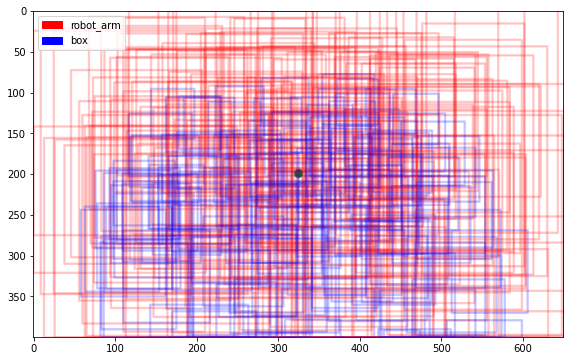

In [ ]:
draw_bbox_heatmap(synth_data, synth_metadata, synth_bboxes)

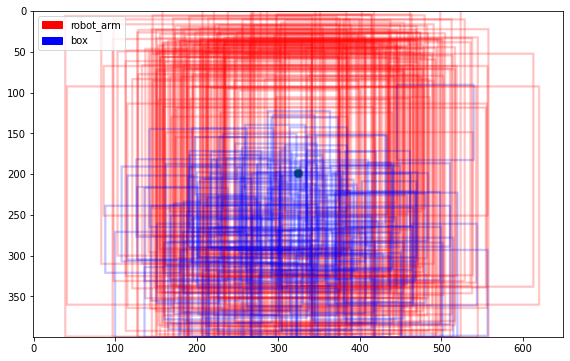

In [ ]:
draw_bbox_heatmap(real_data, real_metadata, real_bboxes)

### Calculate bounding box areas and visualize distribution

In [ ]:
def calculate_bbox_areas(bboxes):
    robot_areas = []
    box_areas = []
    areas = {}
    for idx, box_list in enumerate(bboxes["XYWH"]):
        for box in box_list:
            area = box[2] * box[3]
            if idx == 0: 
                robot_areas.append(area) 
            else: box_areas.append(area)
    
    areas["robot"] = robot_areas
    areas["box"] = box_areas
    return areas

In [ ]:
def draw_area_bars(ref_W, ref_H, areas_dict, title=""):
    m_areas = {}
    indices = {}
    values = {}
    for k in areas_dict.keys():
        m_areas[k] = sum(areas_dict[k])/len(areas_dict[k])
        indices[k] = [i for i in range(len(areas_dict[k]))]
        values[k] = [v for v in areas_dict[k]]    
    fig = plt.figure(figsize=(7.5, 4))
    ax = fig.add_axes([0,0,1,1])       
    ax.bar(indices["robot"], values["robot"], color='r')
    ax.bar(indices["box"], values["box"], color='b')
    plt.axhline(m_areas["robot"], color='grey', linestyle='dashed')
    plt.axhline(m_areas["box"], color='grey', linestyle='dashed')
    
    red_patch = mpatches.Patch(color='red', label='robot_arm')
    blue_patch = mpatches.Patch(color='blue', label='box')
    plt.legend(handles=[red_patch, blue_patch], loc='upper left')
    plt.title(title)
    plt.savefig("bbox_area_values.png")
    plt.show()
    
    img_area = ref_W * ref_H
    print_area_metadata(img_area, m_areas)

In [ ]:
def print_area_metadata(img_area, m_areas):
    robot_ratio = (m_areas["robot"]/img_area)*100 
    box_ratio =  (m_areas["box"]/img_area)*100  
    print("Robot-bboxes: \tMean-area in pixels: {}, covering {}% of image area.".format(round(m_areas["robot"], 2), round(robot_ratio, 2)))
    print("Box-bboxes: \tMean-area in pixels: {}, covering {}% of image area.".format(round(m_areas["box"], 2), round(box_ratio, 2)))

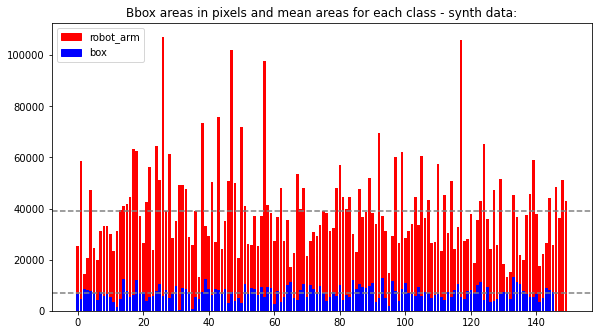

Robot-bboxes: 	Mean-area in pixels: 39128.65, covering 15.05% of image area.
Box-bboxes: 	Mean-area in pixels: 7010.79, covering 2.7% of image area.


In [ ]:
synth_areas = calculate_bbox_areas(synth_bboxes)
ref_W = synth_data[0]["width"]
ref_H = synth_data[0]["height"]
draw_area_bars(ref_W, ref_H, synth_areas, "Bbox areas in pixels and mean areas for each class - synth data:")

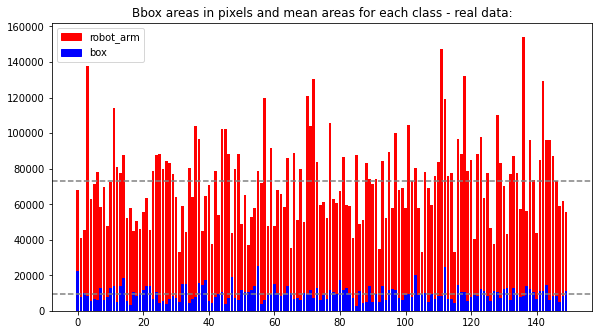

Robot-bboxes: 	Mean-area in pixels: 72933.37, covering 28.05% of image area.
Box-bboxes: 	Mean-area in pixels: 9599.67, covering 3.69% of image area.


In [ ]:
real_areas = calculate_bbox_areas(real_bboxes)
ref_W = real_data[0]["width"]
ref_H = real_data[0]["height"]
draw_area_bars(ref_W, ref_H, real_areas, "Bbox areas in pixels and mean areas for each class - real data:")

### Calculate distances between boxes and image center

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_distances(A_XYWH, B_XYWH, flat_list=False):
    A_m = []
    B_m = []
    if any(isinstance(a, list) for a in A_XYWH) and flat_list:
        A_XYWH = flatten(A_XYWH)

    for a in A_XYWH:
        a_m = (a[0] + a[2]/2, # x + W/2
               a[1] + a[3]/2) # y + H/2
        A_m.append(a_m)
            
    if any(isinstance(b, list) for b in B_XYWH) and flat_list:
        B_XYWH = flatten(B_XYWH)
        
    for b in B_XYWH:
        b_m = (b[0] + b[2]/2, 
               b[1] + b[3]/2) 
        B_m.append(b_m)

    dists = [math.hypot(x_b - x_a, y_b - y_a) for (x_a,y_a) in A_m for (x_b,y_b) in B_m]
    return dists

In [ ]:
def print_dist_metadata(dists, title):
    m_dist = sum(dists)/len(dists)
    max_dist = max(dists)
    min_dist = min(dists)
    print(title)
    print("\t--> mean: {}, min: {} and max: {}.".format(
        round(m_dist, 2), round(min_dist, 2), round(max_dist, 2)))

In [ ]:
img_coords = [(0,0,synth_data[0]["width"],synth_data[0]["height"])]
d_img = calculate_distances(synth_bboxes["XYWH"], img_coords, True)
print_dist_metadata(d_img, "Distances and mean of all bboxes to image center in pixels - synth data:")

Distances and mean of all bboxes to image center in pixels - synth data:
	--> mean: 129.81, min: 2.92 and max: 295.7.


In [ ]:
img_coords = [(0,0,real_data[0]["width"],real_data[0]["height"])]
d_img = calculate_distances(real_bboxes["XYWH"], img_coords, True)
print_dist_metadata(d_img, "Distances and mean of all bboxes to image center in pixels - real data:")

Distances and mean of all bboxes to image center in pixels - real data:
	--> mean: 77.87, min: 3.54 and max: 229.9.


In [ ]:
d = calculate_distances(synth_bboxes["XYWH"][0],
                        synth_bboxes["XYWH"][1])
print_dist_metadata(d, "Distances and mean of robot bboxes to box bboxes in pixels - synth data:")

Distances and mean of robot bboxes to box bboxes in pixels - synth data:
	--> mean: 178.76, min: 1.8 and max: 496.22.


In [ ]:
d = calculate_distances(real_bboxes["XYWH"][0],
                      real_bboxes["XYWH"][1])
print_dist_metadata(d, "Distances and mean of robot bboxes to box bboxes in pixels - real data:")

Distances and mean of robot bboxes to box bboxes in pixels - real data:
	--> mean: 119.36, min: 1.0 and max: 336.51.
